In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import math
from torch.nn import functional as F
import numpy as np
import tiktoken

### E0 - Fetching the Original Model

Let's examine the weights of the original model.

#### Model Components

* **Token Embeddings:** `transformer.wte.weight` is a lookup table for the model's vocabulary. Its size is `torch.Size([50257, 768])`, meaning there are **50,257** unique tokens, each with a vector representation (embedding) of **768** dimensions.

* **Positional Embeddings:** `transformer.wpe.weight` is a lookup table that provides an embedding for each position in the sequence. Its size is `torch.Size([1024, 768])`, which corresponds to **1,024** possible positions, each with a **768-dimensional** embedding.


In [2]:
from transformers import GPT2LMHeadModel

model_hf = GPT2LMHeadModel.from_pretrained('gpt2') #124M
sd_hf = model_hf.state_dict()

# Print key and values of the tensor
for k in sd_hf:
    print(k, sd_hf[k].shape)

/Users/soeren/code/gpt2/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/soeren/code/gpt2/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

### Decoder Blocks (Layers)

The `transformer.h` part of the names refers to the "hidden" or **decoder blocks**, which are the core computational units of the Transformer model. The number `0` (e.g., `transformer.h.0`) indicates the first block. A full model would have multiple blocks (e.g., `transformer.h.1`, `transformer.h.2`, etc.).

Each decoder block contains two main components: a **Multi-Head Self-Attention** mechanism and a **Multi-Layer Perceptron (MLP)**.

**1. Layer Normalization**

* **`transformer.h.0.ln_1.weight`** and **`transformer.h.0.ln_1.bias`**: These are the parameters for the first **layer normalization** layer. This layer normalizes the data to have a mean of 0 and a standard deviation of 1 before it enters the attention mechanism. This helps stabilize training.

**2. Attention Mechanism**

* **`transformer.h.0.attn.c_attn.weight`**: This weight matrix is used to compute the **query, key, and value** vectors for the attention mechanism.
    * `torch.Size([768, 2304])`: The input dimension is **768** (the embedding size). The output dimension is **2304**, which is three times the input dimension (`3 * 768`), because it's used to generate the three vectors (query, key, and value) at once.
* **`transformer.h.0.attn.c_attn.bias`**: This is the corresponding bias vector for `c_attn`.
* **`transformer.h.0.attn.c_proj.weight`** and **`transformer.h.0.attn.c_proj.bias`**: These parameters project the concatenated output of the attention heads back to the original `768-dimensional` space.

**3. Second Layer Normalization**

* **`transformer.h.0.ln_2.weight`** and **`transformer.h.0.ln_2.bias`**: These are the parameters for the second layer normalization, which is applied before the data enters the MLP.

**4. Multi-Layer Perceptron (MLP)**

* **`transformer.h.0.mlp.c_fc.weight`** and **`transformer.h.0.mlp.c_fc.bias`**: These are the parameters for the first layer of the MLP, a fully connected feed-forward network.
    * `torch.Size([768, 3072])`: It expands the `768-dimensional` data to a larger, `3072-dimensional` representation (`4 * 768`).
* **`transformer.h.0.mlp.c_proj.weight`** and **`transformer.h.0.mlp.c_proj.bias`**: These are the parameters for the second layer of the MLP, which projects the data back down to the original `768-dimensional` size.

---

### Follow up questions:

#### Q1 - Why do we need a bias when running layer normalization (`transformer.h.0.ln_1.bias`)

We need a bias for layer normalization to allow the normalized outputs to be shifted to any range. Without a bias, the layer normalization output would always have a mean of zero, which might not be the optimal mean for the subsequent layer. The bias, along with the scale parameter, provides the layer with the flexibility to learn the best possible mean and standard deviation for its output, improving the model's expressive power and helping it learn more complex patterns.

**How It Works**

Layer normalization standardizes the inputs to a layer to have a mean of 0 and a variance of 1. It then applies two learnable parameters: a **scale parameter ($\gamma$)** and a **bias parameter ($\beta$)**. The final output of the layer normalization is calculated using the following formula:

$$\text{Output} = \gamma \cdot \frac{x - \mu}{\sigma} + \beta$$

* **$x$**: The input to the layer.
* **$\mu$**: The mean of the input.
* **$\sigma$**: The standard deviation of the input.
* **$\frac{x - \mu}{\sigma}$**: This is the core normalization step, ensuring the output has a mean of 0 and a variance of 1.
* **$\gamma$**: The learnable scale parameter.
* **$\beta$**: The learnable bias parameter.

The bias parameter ($\beta$) allows the model to shift the mean of the normalized output. This is crucial because while normalizing the data to a mean of zero is a good starting point for training, the ideal mean for a specific layer's input might not be zero. The bias allows the network to find the optimal data distribution for each layer, which helps in faster convergence and better performance. In essence, the scale and bias parameters allow the model to undo the normalization if needed, giving it the flexibility to learn the most effective data representation for the task at hand.

<img src="images/trans_arch.jpg" alt="Alt text" width="500"/>

# E1 - Linear layers

A **linear layer** (or **fully connected layer**) in a neural network is a layer where each input neuron is connected to each output neuron with a certain weight. This layer performs a linear transformation on the input vector.

Given an input vector $\mathbf{x} \in \mathbb{R}^n$ and a weight matrix $\mathbf{W} \in \mathbb{R}^{m \times n}$, and a bias vector $\mathbf{b} \in \mathbb{R}^m$, the output $\mathbf{y}$ of a linear layer can be computed as:

$$
\mathbf{y} = \mathbf{W} \mathbf{x} + \mathbf{b}
$$

- **Input Vector** $\mathbf{x}$: $\begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_n \end{bmatrix}$
- **Weight Matrix** $\mathbf{W}$: $\begin{bmatrix} w_{11} & w_{21} & \cdots & w_{n1} \\ w_{12} & w_{22} & \cdots & w_{n2} \\ \vdots & \vdots & \ddots & \vdots \\ w_{1m} & w_{2m} & \cdots & w_{nm} \end{bmatrix}$
- **Bias Vector** $\mathbf{b}$: $\begin{bmatrix} b_1 \\ b_2 \\ \vdots \\ b_m \end{bmatrix}$
- **Output Vector** $\mathbf{y}$: $\begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_m \end{bmatrix}$

![Alt text](images/q_k_v.png)

If we create the following:

`nn.Linear(3, 4)`

We get a weight matrix according to the dimensionality of of the output neurons $y$

- **Input Vector** $\mathbf{x}$: $\begin{bmatrix} x_1 \\ x_2 \\ x_3 \end{bmatrix}$
- **Weight Matrix** $\mathbf{W} = \begin{bmatrix}
w_{11} & w_{21} & w_{31} \\
w_{12} & w_{22} & w_{32} \\
w_{13} & w_{23} & w_{33} \\
w_{14} & w_{24} & w_{34}
\end{bmatrix}$
- **Bias Vector** $\mathbf{b}$: $\begin{bmatrix} b_1 \\ b_2 \\ b_3 \\ b_4 \end{bmatrix}$
- **Output Vector** $\mathbf{y}$: $\begin{bmatrix} y_1 \\ y_2 \\ y_3 \\ y_4 \end{bmatrix}$



In [29]:
class MyLinearLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)

    # Define flow
    def forward(self, x):
        return self.linear(x)

input_size = 3
output_size = 9

x = torch.randn(1, input_size)  # Random input tensor

model = MyLinearLayer(input_size, output_size)
output = model(x)

state_dict = model.state_dict()

# Print of the state_dict
print(state_dict.keys())

# Access weights of a specific layer
print(state_dict['linear.weight'])

# When we look at the weight matrix, it's had exactly the dimension we expectec based on the math above.

odict_keys(['linear.weight', 'linear.bias'])
tensor([[-0.4671,  0.2912, -0.4283],
        [-0.0576, -0.1183, -0.1192],
        [ 0.5676,  0.1285,  0.5333],
        [ 0.4620, -0.0255, -0.4831],
        [ 0.0646, -0.3111,  0.1845],
        [-0.1656,  0.2905, -0.3450],
        [ 0.2120, -0.0692,  0.4314],
        [ 0.1323, -0.3696, -0.4060],
        [-0.1731,  0.1358, -0.2280]])


# E2 - Mask

In [30]:
block_size = 10  # The maximum length of the input sequence

ones_matrix = torch.ones(block_size, block_size)
lower_triangular_matrix = torch.tril(ones_matrix)
mask = lower_triangular_matrix.view(1, 1, block_size, block_size)

print(f"""{ones_matrix}, \n\n {lower_triangular_matrix} \n\n {mask}""")

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), 

 tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 

# E3 - Splitting

In [31]:
batch_size = 4  # Number of examples in the batch
sequence_length = 3  # Length of the sequence for each example (e.g. "I love dogs"), assuming "I love dogs" would result in three tokens: "I", "love", "dogs"
embedding_dimension = 5  # Dimension of the embedding space

# Create a sample tensor with random values
input_tensor = torch.randn(batch_size, sequence_length, embedding_dimension)
print("\n\nInput tensor \n\n", input_tensor)

B, T, C = input_tensor.size()

# In a second step we are going to use a linear layer with three times the embedding dimension.
lin_layer = nn.Linear(embedding_dimension, 3 * embedding_dimension)
qkv = lin_layer(input_tensor)
print("\n\nWeights linear layer \n\n", lin_layer.weight)

print("\n\nqkv tensor \n\n", qkv)
q, k, v = qkv.split(embedding_dimension, dim=2)



Input tensor 

 tensor([[[-2.1698,  0.6826, -1.1638,  1.5941,  1.8476],
         [ 1.1437, -0.9423,  1.0330, -1.4596, -0.3861],
         [ 0.3245,  1.5895, -1.0048, -0.8807,  1.3424]],

        [[-0.8365, -2.1496,  0.5740, -0.5460, -0.9132],
         [-0.2894,  0.0986, -0.9958, -0.8240, -1.0636],
         [ 0.3557, -0.6433,  1.0517,  1.5815,  0.6039]],

        [[ 0.8503, -0.3699,  0.5846, -0.8663,  1.4372],
         [ 0.1906, -0.6420,  0.3558,  0.1981, -1.4585],
         [ 0.4030,  0.3126, -0.1588,  0.8097,  0.3528]],

        [[ 1.0425, -0.0618, -0.1667, -1.1555, -0.0031],
         [-0.7524,  0.7781, -1.0059, -0.0085,  0.8720],
         [-0.8803, -0.6547, -1.0416,  0.7096,  1.1041]]])


Weights linear layer 

 Parameter containing:
tensor([[-0.1216,  0.2178,  0.1190, -0.0951,  0.3432],
        [-0.3136,  0.1212,  0.3269, -0.0258,  0.1089],
        [ 0.1307,  0.0847,  0.3193,  0.1209, -0.0460],
        [ 0.4076, -0.2450, -0.0261, -0.3485,  0.1512],
        [ 0.0374, -0.1124,  0.0687

In [32]:
n_head = 1
# B = batch
# T = sequence length
# head = number of heads
# C = embedding dimension --> The tensor k is being split into head smaller chunks. This is a common step in multi-head attention, where the input is projected into multiple subspaces corresponding to different heads.
k = k.view(B, T, n_head, C // n_head).transpose(1, 2) # transpose starts from zero. Hence, we are transposing T and head.
q = q.view(B, T, n_head, C // n_head).transpose(1, 2)
v = v.view(B, T, n_head, C // n_head).transpose(1, 2)
k

tensor([[[[-0.9911,  0.9753, -0.7692, -1.1579,  0.2402],
          [ 0.3976, -0.6163,  0.4847,  0.2252, -0.1138],
          [-0.8723,  0.2586, -0.5428, -0.3633,  0.8454]]],


        [[[ 0.5515, -0.3368,  0.6662,  0.0460, -0.8434],
          [-0.2009,  0.1522,  0.2214,  0.0523, -0.2482],
          [-0.0440,  0.4607,  0.0848, -0.9409,  0.0018]]],


        [[[-0.1466, -0.1997,  0.0312, -0.3804,  0.5951],
          [ 0.2301,  0.0933,  0.4414, -0.1020, -0.6204],
          [-0.4054,  0.5986, -0.0323, -0.7513,  0.2790]]],


        [[[-0.1281, -0.0597,  0.2834, -0.1052,  0.3549],
          [-0.7024,  0.4551, -0.3988, -0.5213,  0.3105],
          [-0.5183,  0.8020,  0.0971, -1.0180,  0.3815]]]],
       grad_fn=<TransposeBackward0>)

#E4 - Attention

In [33]:
# Dimensions of the tensors: batch, sequence length, number of heads, embedding dimension (i.e. the embedding)
print(q.shape, k.shape, v.shape)


print(q)
print("\n\n")
print(k.transpose(-2, -1))

# What happens is that the transformation allows us to multiply the q and k tensors.


torch.Size([4, 1, 3, 5]) torch.Size([4, 1, 3, 5]) torch.Size([4, 1, 3, 5])
tensor([[[[ 0.7386,  0.3196, -0.4828, -1.6039, -0.4774],
          [-0.2326, -0.3628,  0.2475,  0.8140,  0.2911],
          [ 0.7139, -0.2919, -0.3052, -0.0276,  0.2217]]],


        [[[-0.5773, -0.1191, -0.1254, -0.0835, -0.1791],
          [-0.3661, -0.5406, -0.3913, -0.2963, -0.4727],
          [-0.0191, -0.0440,  0.4980, -0.4911, -0.5011]]],


        [[[ 0.4436, -0.1647,  0.1024,  0.6348,  0.5979],
          [-0.6577, -0.4084,  0.1820, -0.3703, -0.7721],
          [ 0.0265, -0.3461,  0.1169, -0.4435, -0.5044]]],


        [[[-0.0688, -0.5827, -0.0550,  0.5402,  0.1298],
          [ 0.4236, -0.1266, -0.3879, -0.6427, -0.1940],
          [ 0.1341, -0.2651, -0.4613, -0.5580, -0.2133]]]],
       grad_fn=<TransposeBackward0>)



tensor([[[[-0.9911,  0.3976, -0.8723],
          [ 0.9753, -0.6163,  0.2586],
          [-0.7692,  0.4847, -0.5428],
          [-1.1579,  0.2252, -0.3633],
          [ 0.2402, -0.1138,  

In [34]:
# Check batches 0
# This transformation allows us to multiply the q and k tensors.
print(f"{k[0]}, \n\n {k.transpose(-2, -1)[0]}")

# The @ operator is used for matrix multiplication.
# k.size(-1) is the length of the embeddings.
att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))

tensor([[[-0.9911,  0.9753, -0.7692, -1.1579,  0.2402],
         [ 0.3976, -0.6163,  0.4847,  0.2252, -0.1138],
         [-0.8723,  0.2586, -0.5428, -0.3633,  0.8454]]],
       grad_fn=<SelectBackward0>), 

 tensor([[[-0.9911,  0.3976, -0.8723],
         [ 0.9753, -0.6163,  0.2586],
         [-0.7692,  0.4847, -0.5428],
         [-1.1579,  0.2252, -0.3633],
         [ 0.2402, -0.1138,  0.8454]]], grad_fn=<SelectBackward0>)


# E5 - Mask

In [35]:

# We now apply the mask and set.
# We replace values with '-inf' where the mask is zero.
# While mask has the dimensions of the the sequence length we define in the overall setting (e.g. 1024)
# It automatically adapts to the sequence length of the current batch (e.g. attn)
att = att.masked_fill(mask=mask[:, :, :T, :T] == 0, value=float('-inf'))
print(att)

tensor([[[[ 0.7574,    -inf,    -inf],
          [-0.5305,  0.1794,    -inf],
          [-0.3007,  0.1272, -0.1499]]],


        [[[-0.0960,    -inf,    -inf],
          [ 0.0467,  0.0029,    -inf],
          [ 0.3292,  0.0922,  0.2164]]],


        [[[ 0.0382,    -inf,    -inf],
          [-0.0604,  0.1823,    -inf],
          [-0.0280,  0.1716, -0.0131]]],


        [[[ 0.0077,    -inf,    -inf],
          [-0.0706,  0.0333,    -inf],
          [-0.0667,  0.0867,  0.0715]]]], grad_fn=<MaskedFillBackward0>)


# E6 - Merging

### Step 1 - Check for contigiousy
Contiguous Memory:  `[   Book 1   ] [   Book 2   ] [   Book 3   ] [   Book 4   ] [   Book 5   ]`

Non-Contiguous Memory:  `[         ] [   Book 3   ] [         ] [   Book 1   ] [   Book 2   ]`

Think of `.contiguous()` as a librarian who reorganizes the books on the shelf:
`[   Book 1   ] [   Book 2   ] [   Book 3   ] [   Book 4   ] [   Book 5   ]`

### Step 2 - Merging the `heads`
We started out with `n_head`. In reality we would use several heads to capture different different "perspectives".
In order to merge the 'heads' we apply .view(B, T, C) to our originally four-dimensional tensor (B, T, n_heads, C).
We are essentially flattening (combining) the elements in the fourth dimension into the existing dimensions (B, T, C).

In [36]:
att = F.softmax(att, dim=-1)
y = att @ v # matrix multiplication attention * values
y = y.transpose(1, 2).contiguous().view(B, T, C)
print(y)
c_proj = nn.Linear(embedding_dimension, embedding_dimension)
y = c_proj(y)

print(y)

tensor([[[ 1.2305,  0.8814, -0.9152, -2.4855,  0.9535],
         [-0.1131, -0.2692, -0.0322, -0.1630,  0.5519],
         [ 0.2572, -0.0327,  0.0725, -0.8466,  0.6060]],

        [[-0.8941, -0.7697, -0.5080,  0.7747,  0.1445],
         [-0.5946, -0.6445, -0.2587,  0.0802, -0.0661],
         [-0.3868, -0.4224, -0.3479,  0.2394,  0.2676]],

        [[ 0.1617, -0.1020,  0.4303, -0.1301,  1.0464],
         [-0.3197, -0.4304,  0.0063,  0.3000,  0.3765],
         [-0.1145, -0.2716, -0.0230,  0.0534,  0.4297]],

        [[-0.1615, -0.4460,  0.5462, -0.0688,  0.3058],
         [ 0.2518, -0.0812,  0.1774, -0.9262,  0.4143],
         [ 0.3955,  0.0739,  0.0032, -1.0233,  0.5286]]],
       grad_fn=<ViewBackward0>)
tensor([[[-0.0579, -0.1446, -0.1626, -0.6017,  2.0666],
         [ 0.5001, -0.1250, -0.2764,  0.1458,  0.4454],
         [ 0.4394, -0.2966, -0.2468,  0.0471,  0.7320]],

        [[ 0.4326,  0.2188, -0.2668,  0.1565,  0.0176],
         [ 0.3576, -0.0469, -0.2393,  0.1365,  0.1449],
      

In [37]:
# When we compare the shape of the output tensor with the input tensor, we see that the dimensions are the same.
# batch_size=4, sequence_length=3, embedding_dimension=5
print(input_tensor.shape, y.shape)

torch.Size([4, 3, 5]) torch.Size([4, 3, 5])


# E7 - Stacking blocks

In [ ]:
# Instead of 'test' the origial code uses the class Block(config)
# This leads to a list with n.layers of blocks. E.g. n.layer = 3 --> 3 blocks stacked on each other
# In the original code we inititaite the blocks with the config n times (range(n))
blocks = ['test' for _ in range(3)]
print(blocks)

['test', 'test', 'test']


# E8 - ModuleDict

`ModuleDict` allows to create a dict with layers as items.
It therefore allows us to store a collection of modules in a single object.

In [1]:
import torch
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleDict({
            'lin1': nn.Linear(5, 20),  # Input size is 5, output size is 20
            'lin2': nn.Linear(20, 100),  # Input size is 20, output size is 3
        })

    def forward(self, x):
        x = self.layers['lin1'](x)
        x = self.layers['lin2'](x)
        return x

# Dummy tensor
dummy_input = torch.randn(3, 5)  # Batch size of 3, input size of 5

model = MyModel()
output = model(dummy_input)
print("Output shape:", output.shape)

Output shape: torch.Size([3, 100])


# E9 - Positional Embeddings

In [40]:
import numpy as np

block_size = 200 # The maximum length of the input sequence
n_embd = 5
T = 100 # Sequence length

# Arrange returns a 1D tensor with values from the start (0 in this case) to the end (T), excluding T.
# it's similar to Python’s built-in range function but returns a tensor instead of a list.
pos = torch.arange(start=0, end=T, step=1, dtype=torch.long, device='cpu') # Shape (T)
wpe = nn.Embedding(block_size, n_embd)
pos_emd = wpe(pos)

numpy_array = pos_emd.detach().numpy()

# The the number '1' is embedded into a 5-dimensional vector.
print(pos[1], numpy_array[1])

tensor(1) [ 0.6777694  -1.5703939   1.3001819  -0.8920295  -0.18858036]


# E10 - Regular Embeddings

In [41]:
import tiktoken

enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode("I like dogs!")
print(tokens) # Check tokens created here: https://tiktokenizer.vercel.app/?model=gpt2

tokens = torch.tensor(tokens, dtype=torch.long).unsqueeze(0)  # Shape: (1, 8)

n_embd = 64  # Adjust embedding dimension as needed
wte = nn.Embedding(50257, 5) # 50257 is the number of tokens in the GPT-2 vocabulary. This needs to match.
embeddings = wte(tokens)  # Shape: (1, 8, n_embd)

embeddings[0]


[40, 588, 6844, 0]


tensor([[ 0.3620, -1.2837, -0.3968,  0.6417,  0.1096],
        [-0.4312,  1.9651,  0.2502,  2.1025, -0.0606],
        [ 1.6636,  0.5339,  2.7540, -0.9897, -0.3627],
        [ 0.0473,  0.4471,  0.3962, -0.1315,  0.4331]],
       grad_fn=<SelectBackward0>)

# E11 - Multinomal distribution

I case we have a set of probabilities a multinomal distribution can help to introduce some randomness.
We see, for example, that p=0.8 is not picked 80% of the time. In context of a LLM we want to introduce some randomness:
If we only choose the most probable token at each step this would leading to repetitive and predictable text.

In [42]:
from scipy.stats import multinomial

# Parameters:
n = 100  # number of trials
p = [0.1, 0.1, 0.8]  # probabilities of each outcome

# Generate random samples
samples = multinomial.rvs(n, p, size=5)  # Generate 10 samples

print(samples)

[[14 11 75]
 [11 11 78]
 [ 9  8 83]
 [13 12 75]
 [13 14 73]]


# E12 - Weight tying

Weight tying works by reducing the redundancy between the embedding and output layers in a neural network. This reduction leads to fewer parameters, faster training, and better generalization, making the model more efficient and effective, especially for language-related tasks.

In [ ]:
import torch
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleDict({
            'lin1': nn.Linear(20, 20),  # Input size is 5, output size is 20
            'lin2': nn.Linear(20, 20),  # Input size is 20, output size is 3
        })

        # Tye the weights of the second linear layer to the weights of the first linear layer.
        self.layers.lin2.weight = self.layers.lin1.weight

    def forward(self, x):
        x = self.layers['lin1'](x)
        x = self.layers['lin2'](x)
        return x



# Dummy tensor
dummy_input = torch.randn(3, 20)  # Batch size of 3, input size of 5

model = MyModel()
output = model(dummy_input)

print(model.layers['lin1'].weight - model.layers['lin2'].weight)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0

# E12 - weight sharing

# TODO

# E13 - Residual stream

The residual stream adds the input of an layer to its output.<br>
We are not talking about weights here. We are talking about the acutal- in and outputs.
<br>

Example:<br>
`attn_output, _ = self.attention(x, x, x)`<br>
`x = x + attn_output # Residual connection: add the input 'x' back to the output`<br>
`x = self.norm1(x)`<br>

<br>
The problem with this approch is an explosion of the deviation of the output.

<img src="images/res.png" alt="Alt text" width="200"/>

In [43]:
x = torch.zeros(30)
n = 100
for i in range(n):
    # We create random values with mean 0 and standard deviation 1.
    x += torch.randn(30)
# Just after 100 interations the std moved to >10!
print(x.std())

# We can fix this by dividing the sum by the square root of the number of iterations.
x = torch.zeros(30)
for i in range(n):
    x += n**-0.5 * torch.randn(30)
print(x.std())

tensor(8.2054)
tensor(0.9007)


# E14 - Quantization

Quantization is used to speed up training time and work more memory efficient.
It works as follows:

<img src="images/prec2.png" alt="Alt text" width="400"/>

Different procedures are available with `TF32` being the gold standard for training.

<img src="images/prec1.png" alt="Alt text" width="400"/>

What is missing here is sign (0 for positive and 1 for negative)

### `.unsqueeze()`

In [44]:
"""
Adds a new dimension to the tensor at the specified position. In this case, 0 indicates that the new dimension will be added at the beginning.
Adding this extra dimension is often necessary for batching in PyTorch. Transformer models expect input tensors to have a specific shape, typically [batch_size, sequence_length].
By unsqueezing the tensor, we create a batch dimension, even if there's only one sequence in the batch.
"""

tokens = [101, 2009, 2003, 1037, 3722, 102]
tens = torch.tensor(tokens)

# The shape of the tensor is (6,) because it's a 1D tensor with 6 elements.
# For our model we need a batch dimension, so we add a dimension at the beginning.
print(tens.shape)

tens2 = tens.unsqueeze(0)
print(tens2.shape)

# Repeat the tensor 5 times along the first dimension
tens.unsqueeze(0).repeat(5, 1)

torch.Size([6])
torch.Size([1, 6])


tensor([[ 101, 2009, 2003, 1037, 3722,  102],
        [ 101, 2009, 2003, 1037, 3722,  102],
        [ 101, 2009, 2003, 1037, 3722,  102],
        [ 101, 2009, 2003, 1037, 3722,  102],
        [ 101, 2009, 2003, 1037, 3722,  102]])

### `@classmethod`

In [45]:
class Dog():
    def bark(self):
        print("Woof!")


class Cat():
    @classmethod
    def miau(self):
        print("Miau!")

# Using the Dog class to create an instance of a dog and call the bark method
doggi = Dog()
doggi.bark()

# While the Dog class has an instance method, the Cat class has a class method.
# This means that the Cat class method can be called without creating an instance of the class.
Cat.miau()
try:
    Dog.bark()
except:
    print("Can't call method without instance")

Woof!
Miau!
Can't call method without instance


### `state_dict()`

`state_dict()` returns the different model layers.

h.# stand for the individual heads.

In [46]:
from transformers import GPT2LMHeadModel

model_hf = GPT2LMHeadModel.from_pretrained("gpt2") # Load the GPT-2 model
sd_hf = model_hf.state_dict() # State dict are the raw tensors

print("Model information:", model_hf.config)
print("Number of heads:", model_hf.config.num_attention_heads)
print("Number of layers:", model_hf.config.num_hidden_layers)

for k, v in sd_hf.items():
    print(k, v.shape)

Model information: GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.41.2",
  "use_cache": true,
  "vocab_size": 50257
}

Number of heads: 12
Number of layers: 12
transformer.wte.weight torch.Size([50257, 768])
t

In [47]:
# Inspect a singular layer

# We get a context length `n_ctx` of 1024 tokens with am embedding dimension of 768 per token.
print(sd_hf["transformer.wpe.weight"].shape)

# The first element of the tensor is the embedding for the first token.
sd_hf["transformer.wpe.weight"][0]



torch.Size([1024, 768])


tensor([-1.8821e-02, -1.9742e-01,  4.0267e-03,  1.1347e-02,  6.3824e-02,
        -1.0501e-01,  3.6937e-02, -1.6803e-01, -4.9111e-02, -5.6461e-02,
        -2.4560e-03,  1.3503e-02, -4.1711e-03,  1.5115e-02,  1.6595e-02,
        -1.3808e-01, -6.3314e-03, -4.6150e-02,  2.6675e-02, -2.0417e-01,
         1.3454e-02, -3.6267e-02,  1.9301e-02, -2.5931e-02,  8.0243e-03,
         8.4712e-03, -1.9906e-02,  6.6802e-02,  7.1151e-03, -2.6618e-02,
         2.0829e-02, -3.3732e-02, -8.2898e-03,  9.8622e-03, -2.7369e-02,
        -9.9118e-02, -7.5254e-01,  2.3550e-02, -3.0513e-02,  7.7456e-02,
         3.4301e-03,  7.1132e-03,  2.6479e-02, -1.2113e-03,  1.1219e-01,
        -2.0606e-03, -2.2458e-02, -2.2287e-02,  2.3570e-02,  3.9777e-01,
         1.8856e-02,  2.0280e-02,  6.3043e-01,  2.3146e-02, -4.6894e-02,
         4.0653e+00, -1.7403e-02, -5.1683e-02,  7.2271e-02, -7.9312e-02,
         4.0248e-02,  1.9908e-02, -4.6380e-02, -2.8380e-02,  7.2535e-03,
         2.6772e-02,  1.4972e-03, -2.9892e-01, -1.1

# Flash attention (Fa) [E14]

Fa is a kernel fusion algorithm. Fa needs more flops than the regular procedure but it's way more mindful of the memory (reads and writes).<br>

<img src="images/flash.png" alt="Alt text" width="800"/><br><br>


Our original code looks like this:

<code>
att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))<br>
att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf')<br>
att = F.softmax(att, dim=-1)<br>
y = att @ v
</code>

<br>

Instead we are using:

`F.scaled_dot_product_attention(q, k, v, is_causal=True)`



# E14 - Gradient clipping

## Intuition
GC is used to limit the size of a gradient. If gradient become to large:

- Exploding Gradients: When the gradients are too large, they can cause the model's weights to update excessively, leading to unstable training. The loss might start to fluctuate wildly or even become NaN (not a number).

- Divergence: If the updates to the weights are too large, the model may never converge, meaning it won’t learn properly and might get stuck in a bad state.

## Computational approach

**Calculates the L2 Norm for Each Vector**: For each vector it computes:

$||\mathbf{v}||_2 = \sqrt{x_1^2 + x_2^2 + \ldots + x_n^2}$

Imagine plotting a vector: 

$\mathbf{v} = (3, 4)$<br><br>
$||\mathbf{v}||_2 = \sqrt{3^2 + 4^2} = \sqrt{9 + 16} = 5$<br><br>
$\mathbf{v}_{\text{normalized}} = \left(\frac{3}{5}, \frac{4}{5}\right) = (0.6, 0.8)$<br><br>

If we calculate the L2 norm of the normalized vector. We get 1.
<br>

$\sqrt{0.6^2 + 0.8^2} = \sqrt{0.36 + 0.64} = 1$


[ 0.49671415 -0.1382643 ] [0.51559865]
0.9633736512703545 -0.2681626522057565


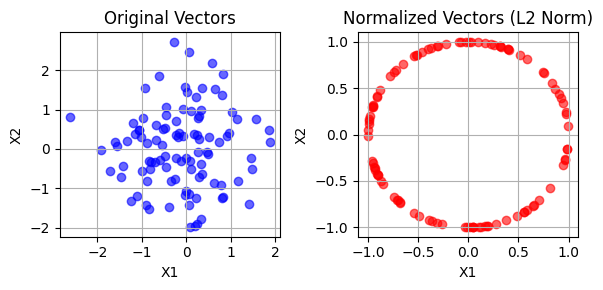

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Generate Random Vectors
np.random.seed(42)  # For reproducibility
vectors = np.random.randn(100, 2)  # Generate 100 random 2D vectors

# Step 2: Plot the Original Distribution
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.scatter(vectors[:, 0], vectors[:, 1], color='blue', alpha=0.6)
plt.title('Original Vectors')
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True)

# Step 3: Apply L2 Norm
norms = np.linalg.norm(vectors, axis=1, keepdims=True)
print(vectors[0], norms[0])

def l2_norm(x):
    norm = (x[0]**2 + x[1]**2)**0.5
    return x[0] / norm, x[1] / norm

a, b = l2_norm(vectors[0])
print(a, b)

normalized_vectors = vectors / norms  # Normalize each vector by its L2 norm

# Step 4: Plot the Normalized Vectors
plt.subplot(1, 2, 2)
plt.scatter(normalized_vectors[:, 0], normalized_vectors[:, 1], color='red', alpha=0.6)
plt.title('Normalized Vectors (L2 Norm)')
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True)

# Show both plots
plt.tight_layout()
plt.show()

# E15 - Learning rate decay

TODO - explain details

<img src="images/dec.png" alt="Alt text" width="800"/><br><br>

In the context of training neural networks, particularly when configuring optimizers, it’s important to distinguish between different types of parameters based on their dimensionality. The distinction we make in the code:

<code>
decay_params = [p for n, p in param_dict.items() if p.dim() >= 2] <br>
nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
</code>

 focuses on whether parameters are weight tensors (2D) or biases and normalization parameters (1D). Here’s a breakdown of why this distinction is important:

### Understanding Parameter Types
#### Weight Tensors (2D):
These are the parameters that involve matrix operations, such as those used in fully connected (dense) layers and convolutional layers.
They are typically represented as 2D tensors (matrices) where:
The first dimension usually corresponds to the number of input features.
The second dimension corresponds to the number of output features.
#### Biases and LayerNorm Parameters (1D):
Bias parameters are typically 1D tensors. Each neuron usually has a bias term that is a scalar (1D) added to the weighted sum of inputs.
Layer normalization parameters are also 1D because they operate across a single dimension (the feature dimension).

# E16 - Kernel Fusion
Kernel fusion is a performance optimization technique commonly used in GPU programming, especially in frameworks like CUDA or machine learning libraries such as PyTorch and TensorFlow. It involves combining multiple computational operations (kernels) into a single kernel to reduce overhead and improve the efficiency of parallel processing on the GPU.

### Why is Kernel Fusion Important?
When multiple kernels are executed on a GPU, there are various costs associated with:

- Kernel Launch Overhead: Every time a kernel is launched, there is some overhead, even if the kernel is relatively simple.
- Memory Access: Separate kernels might require redundant reads and writes to memory, increasing memory bandwidth usage.
- Global Synchronization: Each kernel needs to synchronize with the rest of the program, leading to performance losses.

### By fusing kernels, we can:

- Reduce the number of kernel launches.
- Lower memory access overhead by eliminating redundant memory operations.
- Keep data in shared memory or registers instead of writing it back to global memory between kernels.


In [121]:
# Example for kernel fusion

# Instead of running two operations separately, we can combine them into a single operation.
def k1(a, b):
    c = a + b
    return c

def k2(c):
    d = c*c

for a in range(1000):
    for b in range(1000):
        k2(k1(a, b))

# The kernel fusion is done by combining the two operations into a single operation.
def kf(a, b):
    d = (a + b)**2

for a in range(1000):
    for b in range(1000):
        kf(a, b)

# E17 - Gradient accumulation

Gradient accumulation is a technique used in deep learning to simulate a larger batch size when memory limitations prevent using large batches. Instead of updating the model parameters after every mini-batch (which is standard in most training routines), gradient accumulation collects gradients over several mini-batches and updates the model only after a specified number of mini-batches (or steps).

By using GA we can simulate every arbitrary batch size.

### How its handled in Pytorch

- Gradient Accumulation: In PyTorch, gradients are accumulated rather than overwritten when calling loss.backward(). This means if you call loss.backward() multiple times before updating the model's weights, the gradients from each call will be summed. This behavior is key when performing gradient accumulation in training (i.e., accumulating gradients over several mini-batches).

- Optimizer Step: Once the gradients are accumulated, calling optimizer.step() updates the parameters of the model using the accumulated gradients. The optimizer updates the parameters based on the chosen optimization algorithm (e.g., SGD, Adam, etc.).

- Clearing Gradients: After the optimizer.step() call, you typically call optimizer.zero_grad() to clear the gradients in each parameter. This ensures that the gradients from the next batch of data are calculated independently and not added to the previously accumulated gradients.



# Discussion

### D1

Every head captures a different dimension. We split the embedding by the number of heads:

1) `k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)`

We need to do so as we concatonate the final attention matrices afterwards:

2) `y = y.transpose(1, 2).contiguous().view(B, T, C)`

We see in #2 that we transpose the tensor `y` from four to three dimensions. The transformation to three dimensions merges the `h` Attention matrices.

<img src="images/trans_head.jpg" alt="Alt text" width="300"/>

In [166]:
import numpy as np
from scipy.stats import multinomial

# Parameters:
n = 100  # number of trials
p = [0.1, 0.1, 0.8]  # probabilities of each outcome

# Generate random samples
samples = multinomial.rvs(n, p, size=10)  # Generate 10 samples

print(samples)


[[11  6 83]
 [ 8  9 83]
 [13 15 72]
 [ 9 11 80]
 [17  9 74]
 [13 14 73]
 [10 13 77]
 [12  9 79]
 [12 12 76]
 [ 9  8 83]]


# Training

### Dataset

In [8]:
with open("input.txt", "r") as file:
    text = file.read()

data = text[:1000]
print(data[:100]) # Get the first 1k characters.

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


### Data preparation

We need to generate training examples: sentences.
As we are using self-supervised learning we only need to create batches of sentences.

In [21]:
# gpt2 tokenizer has a compression of 3:1
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode(data)
print(tokens[:24])

# We can convert the tokens to a tensor and reshape it to a 4x6 tensor.
# Here we get for example 4 sequences with 6 tokens each.
# The problem though is that the lost token has no 'label'
buf = torch.tensor(tokens[:24])
x = buf.view(4,6)
print(x)

[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461, 11, 2740, 13]
tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])


In [20]:
buf = torch.tensor(tokens[:24+1])
print(buf)
x = buf[:-1].view(4,6)
y = buf[1:].view(4,6) # y is basically x shifted by one token to the right
print(x)
print(y)

tensor([ 5962, 22307,    25,   198,  8421,   356,  5120,   597,  2252,    11,
         3285,   502,  2740,    13,   198,   198,  3237,    25,   198,  5248,
          461,    11,  2740,    13,   198])
tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])
tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]])


### `buf = torch.tensor(tokens[:B*T+1])`

This only works with texts who are larger than B*T+1

In [57]:
B = 5 # Number of batches
T = 10 # Maximum sequence length

enc = tiktoken.get_encoding('gpt2')
sentence = """
The dog (Canis familiaris or Canis lupus familiaris) is a domesticated descendant of the wolf.
Also called the domestic dog, it was domesticated from an extinct population of Pleistocene wolves over 14,000 years ago.
The dog was the first species to be domesticated by humans.
Experts estimate that hunter-gatherers domesticated dogs more than 15,000 years ago, which was before the development of agriculture.
Due to their long association with humans, dogs have expanded to a large number of domestic individuals and gained the ability to thrive on a starch-rich diet that would be inadequate for other canids.
"""
tokens = enc.encode(sentence)
buf = torch.tensor(tokens[:B*T+1])
x = buf[:-1].view(B,T)
y = buf[1:].view(B,T)
print(buf,"\n")
print(x, "\n")
print(y, "\n")

tensor([  198,   464,  3290,   357,  6090,   271,  5385,   271,   393,  1680,
          271,   300,   929,   385,  5385,   271,     8,   318,   257, 26026,
         3474, 45923,   286,   262, 17481,    13,   220,   198,  7583,  1444,
          262,  5928,  3290,    11,   340,   373, 26026,  3474,   422,   281,
        28881,  3265,   286, 18063,   396, 34973, 23214,   625,  1478,    11,
          830]) 

tensor([[  198,   464,  3290,   357,  6090,   271,  5385,   271,   393,  1680],
        [  271,   300,   929,   385,  5385,   271,     8,   318,   257, 26026],
        [ 3474, 45923,   286,   262, 17481,    13,   220,   198,  7583,  1444],
        [  262,  5928,  3290,    11,   340,   373, 26026,  3474,   422,   281],
        [28881,  3265,   286, 18063,   396, 34973, 23214,   625,  1478,    11]]) 

tensor([[  464,  3290,   357,  6090,   271,  5385,   271,   393,  1680,   271],
        [  300,   929,   385,  5385,   271,     8,   318,   257, 26026,  3474],
        [45923,   286,   262,

In [92]:
class MathOperations:
    def __init__(self, a, b):
        self.a = a
        self.b = b
        print(self)

    def add(self, c):
        return self.a + self.b + c



# Calling the static method without an instance
test = MathOperations(1,2)  # Output: 8


# FAQ

### F1 - Block size / sequence length
- Sequence length (T) is the length of the input sequence, which can be less than or equal to the block size.
- The block size is the maximum length of input sequences that the model can process.

### F2 - Nice numbers
- Always use numbers to the power of two e.g. batch size of 16, 24, 32 etc.
- This is most efficient for the GPU
- Always max out the maximum batch size that fits on your GPU

### F3 - Powers of 2
- Same as for batch optimization, CUDA prefers numbers to the power of 2

### F4
- We increase the vocab size as we want to work with a 'nicer' number. By doing so we are adding 'fake tokens'. While we are doing more flops it still runs more efficient due to the power of 'nice numbers'. 

# Taxonomy

### Flops
- FLOP stands for Floating Point Operation. It's a single mathematical calculation, like adding or multiplying numbers, especially numbers that have decimal points (floating point numbers).

Epoch [1/100], Loss: 42.0545
Epoch [2/100], Loss: 27.8467
Epoch [3/100], Loss: 19.6823
Epoch [4/100], Loss: 12.6528
Epoch [5/100], Loss: 6.6512
Epoch [6/100], Loss: 2.6205
Epoch [7/100], Loss: 0.7446
Epoch [8/100], Loss: 0.1650
Epoch [9/100], Loss: 0.0393
Epoch [10/100], Loss: 0.0175
